In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

import numpy as np
import sys

In [2]:
import matplotlib.pyplot as plt
import matplotlib 
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from captum.attr import Saliency, IntegratedGradients, LRP, GuidedBackprop, NoiseTunnel, GuidedGradCam, InputXGradient

In [4]:
from captum.attr import visualization as viz

In [5]:
sys.path.append("../attacks/")
from utils import get_expl, torch_to_image, load_image,  convert_relu_to_softplus, heatmap_to_image

In [6]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

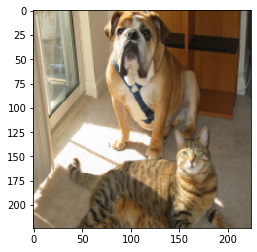

In [15]:
data_mean = np.array([0.485, 0.456, 0.406])
data_std = np.array([0.229, 0.224, 0.225])
x = load_image(data_mean, data_std, device, "../../pytorch-grad-cam/examples/both.png")
plt.imshow(torch_to_image(x, data_mean, data_std))

In [8]:
x_target = load_image(data_mean, data_std, device, "../sample_imagenet/sample_0_target.jpg")

In [39]:
vgg_model = torchvision.models.vgg16(pretrained=True).to(device)
vgg_model = vgg_model.eval()

In [41]:
vgg_model(x).argmax()

tensor(254)

In [47]:
vgg_model(x).argsort(descending=True)

tensor([[254, 243, 242, 245, 282, 292, 180, 247, 676, 262, 534, 281, 163, 246,
         539, 811, 182, 225, 155, 179, 235, 204, 799, 753, 202, 897, 226, 434,
         198, 174, 201, 852, 789, 159, 195, 208, 238, 172, 841, 805, 168, 882,
         184, 284, 999, 251, 898, 651, 287, 151, 161, 285, 193, 286, 793, 209,
         435, 255, 234, 154, 894, 164, 700, 196, 760, 722, 162, 453, 750, 192,
         253, 876, 648, 837, 463, 588, 240, 197, 770, 851, 239, 495, 260, 200,
         478, 729, 771, 785, 608, 191, 519, 896, 831, 248, 212, 244, 797, 158,
         570, 721, 236, 791, 171, 493, 806, 207, 773, 264, 427, 250, 263, 516,
         170, 827, 706, 186, 804, 496, 185, 178, 249, 774, 859, 619, 173, 778,
         291, 211, 548, 273, 514, 861, 607, 846, 543, 227, 788, 515, 691, 189,
         899, 421, 559, 457, 848, 165, 840, 257, 741, 237, 520, 598, 166, 818,
         564, 934, 673, 187, 731, 761, 241, 630, 502, 233, 606, 905, 754, 492,
         868, 725, 482, 194, 708, 412, 757, 440, 836

In [65]:
x_expl_dog = get_expl(vgg_model, x, "lrp", desired_index=254)
x_expl_cat = get_expl(vgg_model, x, "lrp", desired_index=282)

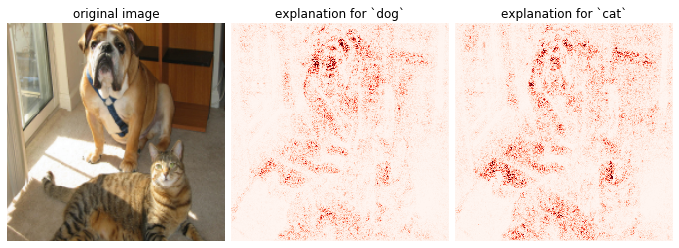

In [66]:
fig, ax = plt.subplots(1,3, figsize=(12, 4))
ax[0].imshow(torch_to_image(x, data_mean, data_std))
viz.visualize_image_attr(np.transpose(x_expl_dog.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[1]), use_pyplot=False)
viz.visualize_image_attr(np.transpose(x_expl_cat.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[2]), use_pyplot=False)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title("original image")
ax[1].set_title("explanation for `dog`")
ax[2].set_title("explanation for `cat`")
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig("example_explanation.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

In [10]:
convert_relu_to_softplus(vgg_model, beta=100)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Softplus(beta=100, threshold=20)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Softplus(beta=100, threshold=20)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Softplus(beta=100, threshold=20)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): Softplus(beta=100, threshold=20)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Softplus(beta=100, threshold=20)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Softplus(beta=100, threshold=20)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): S

In [62]:
isinstance(vgg_model.classifier[0], nn.Linear)

True

In [50]:
sigma = (torch.max(x) - torch.min(x)).item() / 5
sigma

0.9447309494018554

In [51]:
sm = Saliency(vgg_model)
sm_smooth = NoiseTunnel(sm)
expl = sm_smooth.attribute(x, target=17, stdevs=sigma, nt_samples=5)

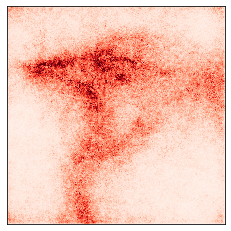

(<Figure size 288x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6f09491160>)

In [52]:
viz.visualize_image_attr(np.transpose(expl.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
#                              sign='positive',
                             outlier_perc=2,
                             fig_size=(4,4))

In [53]:
def UniGrad(model, x, target, num_steps, sigma):
    sm = Saliency(model)
    noisy_x = [x+x.data.new(x.size()).uniform_(-sigma, sigma) for i in range(num_steps)]
    expl = [sm.attribute(img, target=target) for img in noisy_x]
    expl = torch.stack(expl)
    expl = torch.mean(expl, dim=0)
    return expl
    

In [54]:
uni_expl = UniGrad(vgg_model, x, 17, 5, sigma=sigma)

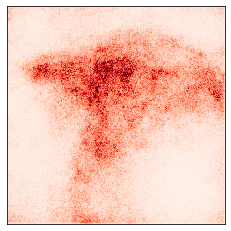

(<Figure size 288x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6f08d4c588>)

In [55]:
viz.visualize_image_attr(np.transpose(uni_expl.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
#                              sign='positive',
                             outlier_perc=2,
                             fig_size=(4,4))

In [22]:
x_expl = get_expl(vgg_model, x, "saliency", desired_index=17, smooth=True)

In [23]:
x_expl_target = get_expl(vgg_model, x_target, "saliency", smooth=True)

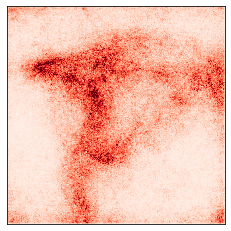

(<Figure size 288x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1f6828eda0>)

In [25]:
viz.visualize_image_attr(np.transpose(x_expl.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
#                              sign='positive',
                             outlier_perc=2,
                             fig_size=(4,4))

In [28]:
delta = torch.zeros_like(x, requires_grad=True) #additive noised
nn.init.normal_(delta, mean=0.0, std=1e-6)
x_adv = x + delta

x_expl_adv = get_expl(vgg_model, x_adv, "saliency", desired_index=17, normalize=True, smooth=True)

In [29]:
x_expl_adv.requires_grad

False

In [21]:
# reproduce the error of LRP
# x: input image, x_target: target image to generate target expl map (both from Imagenet)
# model
vgg_model = torchvision.models.vgg16(pretrained=True)
######
x_index = vgg_model(x).argmax()
x_target_index = vgg_model(x_target).argmax()
lrp = LRP(vgg_model)
org_expl = lrp.attribute(x, target=x_index)
target_expl = lrp.attribute(x_target, target=x_target_index)
###############
delta = torch.zeros_like(x, requires_grad=True) #additive noised
nn.init.normal_(delta, mean=0.0, std=1e-6)
x_adv = x + delta
optimizer = torch.optim.Adam([delta], lr=0.001)

for i in range(20):
    optimizer.zero_grad()
    adv_expl = lrp.attribute(x_adv, target=x_index)
    expl_loss = F.mse_loss(adv_expl, target_expl)
    delta_loss = torch.norm(delta)
    
    loss = 10*expl_loss + 0.01*delta_loss
    print("total: {}, expl: {}, delta: {}".format(loss, expl_loss, delta_loss))
    loss.backward()
    optimizer.step()
    x_adv = x+delta

/home/ubuntu/captum/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


total: 0.03177753835916519, expl: 0.0031773655209690332, delta: 0.0003881945740431547


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [4096, 1000]], which is output 0 of TBackward, is at version 18; expected version 17 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [20]:
def change_relu_inplace(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.ReLU(inplace=False))
        else:
            change_relu_inplace(child)
    return model
change_relu_inplace(vgg_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pad

In [23]:
lrp = LRP(vgg_model)
expl = lrp.attribute(x_adv, target=17)

In [80]:
expl.requires_grad

False

In [37]:
adv_expl1 = get_expl(vgg_model, x_adv, "saliency", desired_index=17)

In [44]:
adv_expl2 = get_expl(vgg_model, x_adv+100*delta, "saliency", desired_index=17)

In [45]:
F.mse_loss(adv_expl1, x_expl_target)

tensor(0.0015, device='cuda:0')

In [46]:
F.mse_loss(adv_expl2, x_expl_target)

tensor(0.0018, device='cuda:0')

In [17]:
from captum.attr import visualization as viz

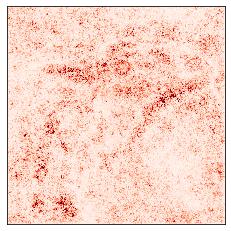

(<Figure size 288x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3bee9178d0>)

In [47]:
viz.visualize_image_attr(np.transpose(adv_expl2.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
#                              sign='positive',
                             outlier_perc=2,
                             fig_size=(4,4))

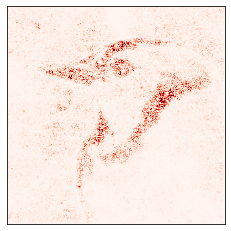

In [40]:
_ = viz.visualize_image_attr(np.transpose(x_expl.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
#                              sign='positive',
                             outlier_perc=2,
                             fig_size=(4,4))


In [12]:
x_expl_smooth = get_expl(vgg_model, x, "saliency", desired_index=17, smooth=True)

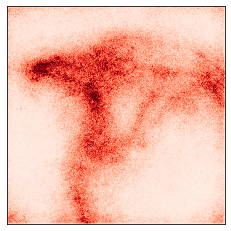

In [13]:
_ = viz.visualize_image_attr(np.transpose(x_expl_smooth.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
#                              sign='positive',
                             outlier_perc=2,
                             fig_size=(4,4))

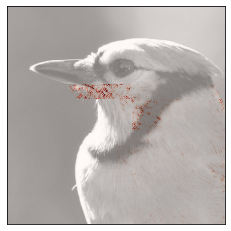

In [20]:
x_expl_guided_gradcam = get_expl(vgg_model, x, "guided_gradcam", desired_index=17, layer=vgg_model.features[28])

_ = viz.visualize_image_attr(np.transpose(x_expl_guided_gradcam.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='blended_heat_map',
                             cmap="Reds",
                             show_colorbar=False,
#                              sign='positive',
                             outlier_perc=2,
                             fig_size=(4,4))

In [94]:
_[1]

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f82d0484c88>)

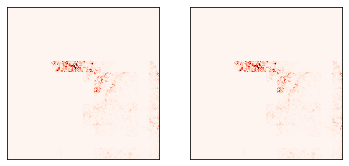

In [125]:
fig, ax = plt.subplots(1,2)

viz.visualize_image_attr(np.transpose(x_expl_guided_gradcam.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
#                              sign='positive',
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[0]), use_pyplot=False)

viz.visualize_image_attr(np.transpose(x_expl_guided_gradcam.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
#                              sign='positive',
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[1]), use_pyplot=False)

In [29]:
import copy

In [29]:
def convert_relu_to_softplus(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.Softplus(beta=1000))
        else:
            convert_relu_to_softplus(child)
    return model

In [73]:
softplus_model = convert_relu_to_softplus(vgg_model)

In [74]:
vgg_model = torchvision.models.vgg16(pretrained=True)
vgg_model = vgg_model.eval().to(device)

In [75]:
vgg_model(x).argmax()

tensor(17, device='cuda:0')

In [77]:
softplus_model(x).argmax()

tensor(898, device='cuda:0')

In [57]:
model

Linear(in_features=1, out_features=1, bias=True)